# Figure 4

In [1]:
# Import packages.
import allel
import matplotlib
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import zarr
# Print version numbers.
print('allel', allel.__version__)
print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('zarr', zarr.__version__)

allel 1.3.5
matplotlib 3.5.2
numpy 1.22.3
pandas 1.4.2
zarr 2.11.3


In [2]:
# Intialize the matplolib styling.
plt.rcParams.update({
    'figure.constrained_layout.use': True,
    'figure.facecolor': 'white',
    'font.family': 'serif',
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'legend.frameon': False,
})

In [3]:
# Import the TGP meta data.
tgp_df = pd.read_csv(
    './data/tgp_mod.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)
# Extract the afr indicies.
afr_idx = tgp_df[tgp_df['SUPERPOP'] == 'AFR'].index.values
# Extract the amr population indicies.
mxl_idx = tgp_df[tgp_df['POP'] == 'MXL'].index.values
pel_idx = tgp_df[tgp_df['POP'] == 'PEL'].index.values
clm_idx = tgp_df[tgp_df['POP'] == 'CLM'].index.values
pur_idx = tgp_df[tgp_df['POP'] == 'PUR'].index.values
# Define the AMR population list.
amr_list = ['MXL', 'PEL', 'CLM', 'PUR']
# Intialize the ancient sample ids.
anc_samps = np.array([
    'USR1', 'CK-13', 'Anzick',
    'CR-01', 'CT-01', 'NC_C',
    'PS-06', 'SC-05', 'SM-02',
    'SN-13', 'SN-17', 'SN-44',
    '2417J', '2417Q', '333B',
    'SRR8144644', 'SRR8144646',
    'SRR8144647', 'SRR8144650',
    'ERR2270782', 'ERR2270783',
    'ERR2270784', 'ERR2270785',

])
# Load the missense mutation dataframe.
den_mis_df = pd.read_csv('./data/denisovan_specific_derived_missense_muts_info.csv')
# Extract the positions of the missense mutations.
den_mis_pos = den_mis_df['POS'].values

In [4]:
# Define a function to exctract a genotype matrix for a specific haplotype region.
def load_hap_region():
    # Intialize the file path.
    path = './data/tgp_mod_arc_anc_748kb.zarr'
    # Load the zarr array.
    zarr_array = zarr.open_group(path, mode='r')
    # Extract the genotype callset.
    chr_callset = zarr_array['12/calldata/GT']
    # Load the positions.
    chr_pos = allel.SortedIndex(zarr_array['12/variants/POS'])
    # Extract the genotype matrix and positions array.
    hap_loc = chr_pos.locate_range(40758000, 40830000)
    hap_idx = np.where(((40758000 <= chr_pos) & (chr_pos <= 40830000)))[0]
    hap_gt = allel.GenotypeArray(chr_callset[hap_loc])
    hap_pos = chr_pos[hap_idx]
    return hap_gt, hap_pos

In [5]:
# Define a function to polarize a genotype matrix.
def polarize_gt(gt):
    # Extract and determine the ancestral sequence.
    anc_seq = np.mean(gt[:, -1, :], axis=1)
    # Intialize an empty genotype matrix.
    p_gt = np.empty_like(gt[:, :-1, :])
    # For every sample...
    for samp in range(gt[:, :-1, :].shape[1]):
        # Extract the haplotypes.
        hap_1 = gt[:, samp, 0]
        hap_2 = gt[:, samp, 1]
        # Polarize.
        p_hap_1 = np.where(anc_seq == 1, np.abs(hap_1 - 1), hap_1)
        p_hap_2 = np.where(anc_seq == 1, np.abs(hap_2 - 1), hap_2)
        # Build the polarized genotype matrix.
        p_gt[:, samp, 0] = np.where(p_hap_1 == 2, -1, p_hap_1)
        p_gt[:, samp, 1] = np.where(p_hap_2 == 2, -1, p_hap_2)
    # Intialize the polarized genotype matrix into sci-kit allele.
    polarized_gt = allel.GenotypeArray(p_gt)
    return polarized_gt

In [6]:
# Define a function to calculate alternative allele frequencies.
def calc_alt_freqs(gt):
    # If there are no altenative alleles...
    if (gt.count_alleles().shape[1] == 1):
        # Calculate alternative allele frequencies.
        alt_freqs = gt.count_alleles().to_frequencies()[:, 0] - 1
    # Else...
    else:
        # Calculate alternative allele frequencies.
        alt_freqs = gt.count_alleles().to_frequencies()[:, 1]
    return alt_freqs

In [7]:
# Load the genotype matrix.
tgp_72kb_gt, tgp_72kb_pos = load_hap_region()
# Polarize the genotype matrix
tgp_72kb_p_gt = polarize_gt(tgp_72kb_gt)
# Create missense mutation mask.
den_mis_mask = np.in1d(tgp_72kb_pos, den_mis_pos)
# Subset the genotype matrix.
den_mis_p_gt = tgp_72kb_p_gt.compress(den_mis_mask, axis=0)

In [8]:
# Intialize the amr matrix.
amr_mat = np.empty((len(amr_list), den_mis_p_gt.shape[0]))
# For every amr population...
for i in range(len(amr_list)):
    # Extract the sample indicies.
    pop_idx = tgp_df[tgp_df['POP'] == amr_list[i]].index.values
    # Fill the matrix.
    amr_mat[i, :] = calc_alt_freqs(den_mis_p_gt.take(pop_idx, axis=1))
# Extract an archaic matrix.
arc_mat = np.array([
    calc_alt_freqs(den_mis_p_gt.take([2350], axis=1)),
    calc_alt_freqs(den_mis_p_gt.take([2348], axis=1)),
    calc_alt_freqs(den_mis_p_gt.take([2349], axis=1)),
    calc_alt_freqs(den_mis_p_gt.take([2347], axis=1))
])
# Extract the poistions, ancestral, and derived alleles.
missense_sites = den_mis_df['POS'].values
anc_alleles = den_mis_df['ANC'].values
der_alleles = den_mis_df['DER'].values
# Intialize a dictionary to determine the allele from angsd.
angsd_allele_dicc = {
    0: 'A', 1: 'C',
    2: 'G', 3: 'T',
}
# Intialize arrays to track allele counts.
anc_counts = np.zeros(den_mis_p_gt.shape[0])
der_counts = np.zeros(den_mis_p_gt.shape[0])
tot_counts = np.zeros(den_mis_p_gt.shape[0])
# For all ancient samples...
for samp in anc_samps:
    # Load the read data.
    anc_df = pd.read_csv(f'./data/{samp}_muc19_ac.csv.gz')
    # Extract the positions array.
    anc_pos = anc_df['pos'].values
    # For every Denisovan missense mutation...
    for i in range(den_mis_p_gt.shape[0]):
        # Extract the missense info.
        pos = missense_sites[i]
        anc = anc_alleles[i]
        der = der_alleles[i]
        # Determine the index in the ancient sample.
        pos_idx = np.where(anc_pos == pos)[0]
        # If the site passed QC in the ancient sample...
        if pos_idx.size > 0:
            # Extract read counts.
            read_counts = anc_df.iloc[pos_idx].to_numpy()[:, -4:].flatten()
            # Determine which allele indicies have more than two reads.
            allele_idx = np.where(read_counts >= 2)[0]
            # If this site is not mono- or bi-allelic.
            if allele_idx.size > 2:
                # Continue to the next site.
                continue
            # Else-if this is a mono-allelic site...
            elif allele_idx.size == 1:
                # Determine the allele identity.
                anc_allele_call = angsd_allele_dicc[allele_idx[0]]
                # If the ancient allele is the derived allele...
                if anc_allele_call == der:
                    # Update the arrays.
                    der_counts[i] += 2
                    tot_counts[i] += 2
                # Else-if the ancient allele is the ancestral allele...
                elif anc_allele_call == anc:
                    anc_counts[i] += 2
                    tot_counts[i] += 2
                # Else...
                else:
                    # Continue to the next site.
                    continue
            # Else-if this is a bi-allelic site...
            elif allele_idx.size == 2:
                # Determine the allele identities.
                anc_allele_calls = np.array([angsd_allele_dicc[j] for j in allele_idx])
                # If the ancient alleles are the same as the hg19 alleles...
                if np.array_equal(np.sort(anc_allele_calls), np.sort(np.array([anc, der]))):
                    # Update the arrays.
                    anc_counts[i] += 1
                    der_counts[i] += 1
                    tot_counts[i] += 2
                # Else...
                else:
                    # Continue to the next site.
                    continue
            # Else...
            else:
                # Continue to the next site.
                continue
        # Else...
        else:
            # Continue to the next site.
            continue
# Compute the derived allele frequency for the ancient samples.
anc_freqs = der_counts / tot_counts
# Compile a dictionary.
mat_dicc = {
    0: np.concatenate((arc_mat, np.array([calc_alt_freqs(den_mis_p_gt.take(afr_idx, axis=1))])), axis=0),
    1: np.concatenate((np.array([anc_freqs]), amr_mat), axis=0),
}
# Intialize an ordered dictionary for plotting.
plot_dicc = {
    0: [
        'Denisovan (n = 2)', 'Chagyrskaya Nean. (n = 2)',
        'Vindija Nean. (n = 2)', 'Altai Nean. (n = 2)',
        f'AFR (n = {int(afr_idx.size * 2)})',
    ],
    1: [
        f'Ancient Americans (n = {int(anc_samps.size * 2)})', f'MXL (n = {int(mxl_idx.size * 2)})', 
        f'PEL (n = {int(pel_idx.size * 2)})', f'CLM (n = {int(clm_idx.size * 2)})', f'PUR (n = {int(pur_idx.size * 2)})',
    ],
}

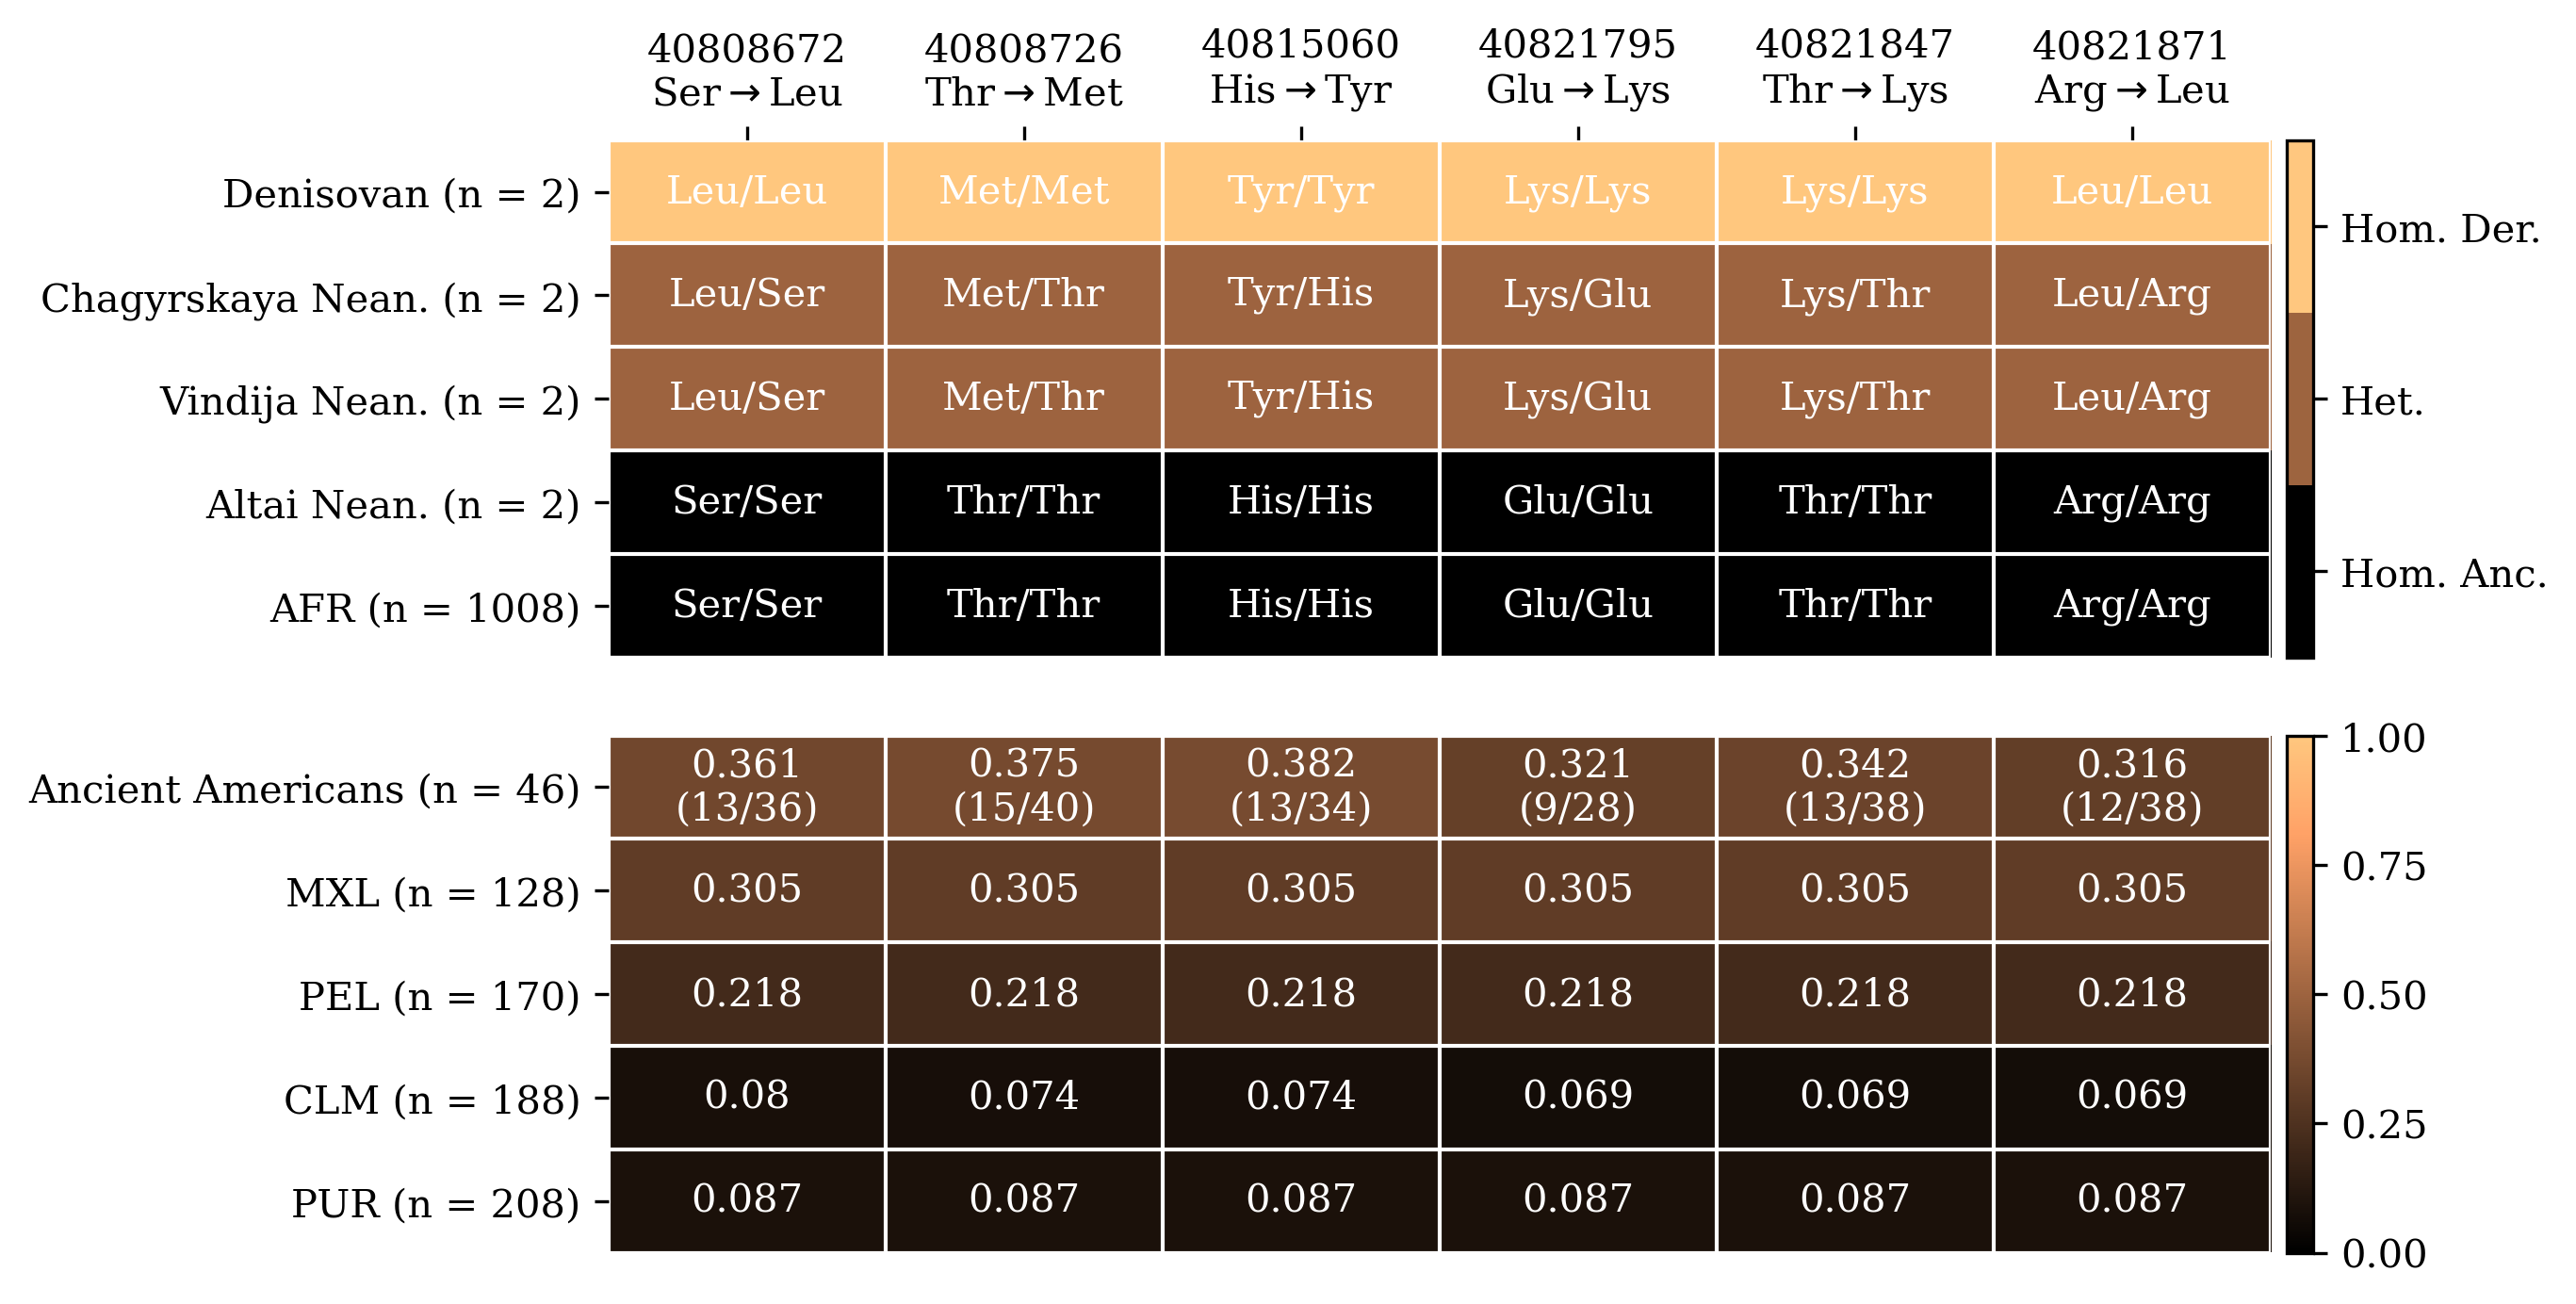

In [9]:
# Intialize the figure and axes.
fig, axes = plt.subplots(
    2, 1, figsize=(9, 4.5), dpi=300,
    sharex=True, sharey=False,
    gridspec_kw={
        'height_ratios': [5, 5],
        'wspace': 0.1, 'hspace': 0.1,
    }
)
# Intialize a list of keys.
key_list = list(plot_dicc.keys())
# For every key...
for i in range(len(key_list)):
    # Extract the key.
    key = key_list[i]
    # If this is the first subplot...
    if i == 0:
        # Intialize color map.
        cmap = matplotlib.cm.get_cmap('copper', 3)
        # Intialize the bounds for the color map.
        bounds = np.linspace(0, 1, 4)
        # Intialzie the cmap and bounds normalization.
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        # Plot the heatmap.
        im = axes[i].imshow(
            mat_dicc[key], cmap=cmap,
            norm=norm, aspect='auto',
        )
        # Configure the labels.
        den_mis_pos = den_mis_df['POS'].values.astype('str')
        den_aa_subs = den_mis_df['AA'].values.astype('str')
        anc_aa = [aa_sub.split('$')[0] for aa_sub in den_aa_subs]
        der_aa = [aa_sub.split('$')[-1] for aa_sub in den_aa_subs]
        x_labels = [den_mis_pos[j]+'\n'+den_aa_subs[j] for j in range(den_mis_df.shape[0])]
        # For every column in the subplot...
        for x in range(den_aa_subs.size):
            # Annotate the amino acids.
            axes[i].text(
                x, 0, der_aa[x]+'/'+der_aa[x],
                ha='center', va='center', color='w',
            )
            axes[i].text(
                x, 1, der_aa[x]+'/'+anc_aa[x],
                ha='center', va='center', color='w',
            )
            axes[i].text(
                x, 2, der_aa[x]+'/'+anc_aa[x],
                ha='center', va='center', color='w',
            )
            axes[i].text(
                x, 3, anc_aa[x]+'/'+anc_aa[x],
                ha='center', va='center', color='w',
            )
            axes[i].text(
                x, 4, anc_aa[x]+'/'+anc_aa[x],
                ha='center', va='center', color='w',
            )
        # Intialize the positions for the colobar.
        cbar = fig.colorbar(
            im, ax=axes[i], pad=0.01,
            ticks=[(bounds[idx] + bounds[idx+1])/2 for idx in range(bounds.size - 1)],
        )
        # Annotate the colobar.
        cbar.ax.set_yticklabels(['Hom. Anc.', 'Het.', 'Hom. Der.'])
        #cbar.set_label('Genotype')
    # Else...
    else:
        # Plot the heatmap.
        im = axes[i].imshow(
            mat_dicc[key], vmin=0, vmax=1,
            aspect='auto', cmap='copper',
        )
        # Configure the ancient data labels.
        anc_ratios = [f'({int(der_counts[j])}/{int(tot_counts[j])})' for j in range(den_mis_df.shape[0])]
        anc_labels = [str(round(mat_dicc[key][0, j], 3))+'\n'+anc_ratios[j] for j in range(den_mis_df.shape[0])]
        # For every column in the subplot...
        for x in range(den_aa_subs.size):
            # Annotate the ancient counts.
            axes[i].text(
            x, 0, anc_labels[x],
            ha='center', va='center', color='w',
        )
        # For every row in the subplot...
        for y in range(1, mat_dicc[key].shape[0]):
            # For every column in the subplot...
            for x in range(mat_dicc[key].shape[1]):
                # Annotate the derived allele frequency.
                axes[i].text(
                    x, y, round(mat_dicc[key][y, x], 3),
                    ha='center', va='center', color='w',
                )
        # Intialize the positions for the colobar.
        cbar = fig.colorbar(im, ax=axes[i], ticks=[0, 0.25, 0.5, 0.75, 1], pad=0.01)
    # Seperate each box.
    axes[i].set_xticks(np.arange(0, den_mis_p_gt.shape[0], 1))
    axes[i].set_yticks(np.arange(0, len(plot_dicc[key]), 1))
    axes[i].set_xticks(
        np.arange(-0.5, den_mis_p_gt.shape[0], 1), minor=True,
    )
    axes[i].set_yticks(
        np.arange(-0.5, len(plot_dicc[key]), 1), minor=True,
    )
    axes[i].grid(which='minor', color='w', linestyle='-', linewidth=1)
    # Set the y-ticks for each plot.
    axes[i].set_yticks(
        np.arange(len(plot_dicc[key])),
        labels=plot_dicc[key],
    )
    # Despine.
    axes[i].tick_params(
        which='minor', left=False,
        bottom=False, labelbottom=False,
    )
    # Remove the ticks.
    axes[i].tick_params(bottom=False, labelbottom=False)
# Move the ticks on top of the DEN row.
axes[0].tick_params(top=True, labeltop=True)
# Configure the x-labels.
x_labels = [den_mis_pos[j]+'\n'+den_aa_subs[j] for j in range(den_mis_df.shape[0])]
# Set and label the x-axis ticks.
axes[0].set_xticks(
    np.arange(den_mis_pos.size),
    labels=x_labels,
)
# Export the plot.
plt.savefig(
    './figures/figure_4.png', format='png',
    facecolor='white', bbox_inches='tight', dpi=300,
)
# Show the plot.
plt.show()